In [1]:
import torch
import numpy as np
import random

In [2]:
seed = 42
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

# Define Model

In [2]:
from utils.DevConf import DevConf
DEV_CONF = DevConf(device='cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
from utils.AttnBlocksConf import AttnBlocksConf
from model.BertDecoder.SentiClassifier import SentiClassifier
from model.CombinationModel import CombinationModel
from utils.const import BlockType

c:\Users\User\miniconda3\envs\NLP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
mapper = SentiClassifier(6, AttnBlocksConf(768, 12, nKVHead=6), BlockType.CROSS, devConf=DEV_CONF)
model = CombinationModel(nClass=6, decoder=mapper, devConf=DEV_CONF)

# Load Data

In [6]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-multilingual-cased", cache_dir='./cache/tokenizer')

In [7]:
import pandas as pd

In [8]:
train = pd.read_csv('data/archive/train.csv')

In [9]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split

In [10]:
class MyDataset(Dataset):
    def __init__(self, df, tokenizer):
        self.df = df
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # print(idx)
        text = self.df.iloc[idx]['ABSTRACT']
        label = torch.tensor([self.df.iloc[idx][i] for i in ["Computer Science","Physics","Mathematics","Statistics","Quantitative Biology","Quantitative Finance"]])
        return text, label
        # return self.tokenizer(text, return_tensors='pt', padding='max_length', truncation=True, max_length=128), label

In [11]:
def collect_fn(batch):
    texts, labels = zip(*batch)
    # print(texts)
    return tokenizer(texts, return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device=DEV_CONF.device), torch.stack(labels).to(DEV_CONF.device)

In [12]:
# def seed_worker(worker_id):
#     worker_seed = torch.initial_seed() % 2**32
#     np.random.seed(worker_seed)
#     random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)

In [13]:
dataset = MyDataset(train, tokenizer)

datasize = len(dataset)
splitIndex = int(datasize * 0.2)
trainDataSize = datasize - splitIndex

train_dataset, test_dataset = random_split(dataset, [trainDataSize, splitIndex])

train_loader = DataLoader(
    train_dataset, collate_fn=collect_fn, batch_size=8, shuffle=True,
    generator=g)
test_loader = DataLoader(
    test_dataset, collate_fn=collect_fn, batch_size=1, shuffle=True,
    generator=g)

In [14]:
print(trainDataSize, splitIndex)

16778 4194


# Train

In [15]:
from torch import nn
from torch.utils.tensorboard import SummaryWriter

In [16]:
lr = 1e-5
epochs = 1
loss_fn = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

In [17]:
def train_fn(model, train_loader, loss_fn, optimizer, epochs):
    model.train()
    writer = SummaryWriter()
    for epoch in range(epochs):
        for i, (data, label) in enumerate(train_loader):
            # print(data['input_ids'])
            # break
            optimizer.zero_grad()
            output = model(**data, NoGradBert=False)
            label = label.repeat(1, 2)
            label = label.view(label.shape[0], 2, -1)
            label = label.mT
            label[:, :, 0] = 1 - label[:, :, 0]
            loss = loss_fn(output, label.float())
            loss.backward()
            optimizer.step()
            if i % 100 == 99:
                print(f"Epoch {epoch+1}/{epochs} - Batch {i+1}/{len(train_loader)} - Loss: {loss.item()}")
                writer.add_scalar('Loss/train', loss.item(), i + 1)
    writer.flush()
    writer.close()

In [18]:
model.train()
train_fn(model, train_loader, loss_fn, optimizer, epochs)
print("Done")

Epoch 1/1 - Batch 100/2098 - Loss: 0.16909562051296234
Epoch 1/1 - Batch 200/2098 - Loss: 0.3301727771759033
Epoch 1/1 - Batch 300/2098 - Loss: 0.18395328521728516
Epoch 1/1 - Batch 400/2098 - Loss: 0.3239040970802307
Epoch 1/1 - Batch 500/2098 - Loss: 0.2956025302410126
Epoch 1/1 - Batch 600/2098 - Loss: 0.138635516166687
Epoch 1/1 - Batch 700/2098 - Loss: 0.1078297346830368
Epoch 1/1 - Batch 800/2098 - Loss: 0.07934728264808655
Epoch 1/1 - Batch 900/2098 - Loss: 0.2069171965122223
Epoch 1/1 - Batch 1000/2098 - Loss: 0.07082235813140869
Epoch 1/1 - Batch 1100/2098 - Loss: 0.15700936317443848
Epoch 1/1 - Batch 1200/2098 - Loss: 0.15459983050823212
Epoch 1/1 - Batch 1300/2098 - Loss: 0.2925944924354553
Epoch 1/1 - Batch 1400/2098 - Loss: 0.16701547801494598
Epoch 1/1 - Batch 1500/2098 - Loss: 0.1077524721622467
Epoch 1/1 - Batch 1600/2098 - Loss: 0.2627100646495819
Epoch 1/1 - Batch 1700/2098 - Loss: 0.15507817268371582
Epoch 1/1 - Batch 1800/2098 - Loss: 0.30545172095298767
Epoch 1/1 -

# Eval

In [19]:
model.eval()

CombinationModel(
  (distilBert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
            (lin1):

In [20]:
# id = 13
# sample = tokenizer(dataset[id][0], return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device=DEV_CONF.device)
# output = torch.where(model(**sample) > 0.5, 1, 0)
# print(output)
# print(dataset[id][1])
# array = output.to("cpu").squeeze().numpy()
# dataset_array = dataset[id][1].numpy()
# for i in range(6):
#     print(array[i], dataset_array[i])
# ans = torch.eq(output.to("cpu"), dataset[id][1])
# print(ans)
# print(torch.all(ans))

In [21]:
# acc = [0] * 6
# testdata = train.sample(1000)
# test_dataset = MyDataset(testdata, tokenizer)

# for data in test_dataset:
#     # print(data[1][0])
#     sample = tokenizer(data[0], return_tensors='pt', padding='max_length', truncation=True, max_length=512).to(device=DEV_CONF.device)
#     output = torch.where(model(**sample) > 0.5, 1, 0)
#     ansList = torch.eq(output.squeeze().to("cpu"), data[1])
#     for i, ans in enumerate(ansList):
#         # print(ans)
#         if ans:
#             acc[i] += 1

In [22]:
# print(acc)

In [23]:
# def test(model, test_loader):
#     acc = [[[0, 0], [0, 0]] for _ in range(6)]
#     for (data, label) in test_loader:
#         output = torch.where(model(**data) > 0.25, 1, 0).squeeze().cpu().numpy()
#         ans = label.squeeze().squeeze().cpu().numpy()
#         for i in range(6):
#             acc[i][output[i]][ans[i]] += 1
#     return acc

In [24]:
def test(model, test_loader):
    acc = [[[0, 0], [0, 0]] for _ in range(6)]
    for (data, label) in test_loader:
        output = torch.argmax(model(**data), dim=2).squeeze().cpu().numpy()
        ans = label.squeeze().squeeze().cpu().numpy()
        for i in range(6):
            acc[i][output[i]][ans[i]] += 1
    return acc

In [25]:
confuse_matrix = test(model, test_loader)

In [26]:
for matrix in confuse_matrix:
    print(matrix)

[[2151, 230], [342, 1471]]
[[2903, 180], [115, 996]]
[[2898, 289], [138, 869]]
[[2875, 256], [239, 824]]
[[4060, 100], [14, 20]]
[[4144, 22], [10, 18]]


[[1606, 887], [66, 1635]]
[[2565, 453], [154, 1022]]
[[2581, 455], [179, 979]]
[[1836, 1278], [112, 968]]
[[4074, 0], [120, 0]]
[[4154, 0], [40, 0]]

[[1513, 980], [45, 1656]]
[[2438, 580], [114, 1062]]
[[2727, 309], [227, 931]]
[[2112, 1002], [155, 925]]
[[4074, 0], [120, 0]]
[[4154, 0], [40, 0]]

[[1885, 608], [102, 1599]]
[[2640, 378], [111, 1065]]
[[2581, 455], [143, 1015]]
[[2388, 726], [135, 945]]
[[4073, 1], [111, 9]]
[[4154, 0], [40, 0]]

[[1893, 600], [63, 1638]]
[[2732, 286], [99, 1077]]
[[2646, 390], [127, 1031]]
[[2474, 640], [59, 1021]]
[[4007, 67], [41, 79]]
[[4116, 38], [12, 28]]

[[1850, 643], [59, 1642]]
[[2556, 462], [54, 1122]]
[[2667, 369], [136, 1022]]
[[2804, 310], [180, 900]]
[[4018, 56], [44, 76]]
[[4145, 9], [27, 13]]

[[1870, 623], [108, 1593]]
[[2322, 696], [83, 1093]]
[[2450, 586], [107, 1051]]
[[2403, 711], [123, 957]]
[[4038, 36], [69, 51]]
[[4150, 4], [25, 15]]

[[1585, 908], [38, 1663]]
[[2578, 440], [111, 1065]]
[[2755, 281], [209, 949]]
[[2377, 737], [93, 987]]
[[4035, 39], [60, 60]]
[[4154, 0], [40, 0]]

[[1656, 837], [45, 1656]]
[[2680, 338], [144, 1032]]
[[2761, 275], [203, 955]]
[[2674, 440], [223, 857]]
[[4048, 26], [73, 47]]
[[4153, 1], [34, 6]]

In [27]:
microacc = [[0, 0], [0, 0]]
for i in range(6):
    for j in range(2):
        for k in range(2):
            microacc[j][k] += confuse_matrix[i][j][k]

In [28]:
print(microacc) # microaveraging, macroaveraging

[[19031, 1077], [858, 4198]]


[[16816, 3073], [671, 4604]]

[[17018, 2871], [701, 4574]]

[[17721, 2168], [642, 4633]]

[[17868, 2021], [401, 4874]]

[[18040, 1849], [500, 4775]]

[[17233, 2656], [515, 4760]]

[[17484, 2405], [551, 4724]]

[[17972, 1917], [722, 4553]]

In [29]:
macro = [{"Recall" : 0, "Precision" : 0, "F1" : 0, "Acc" : 0} for _ in range(len(confuse_matrix))]
for id, matrix in enumerate(confuse_matrix):
    macro[id]["Precision"] = matrix[1][1] / (matrix[1][1] + matrix[1][0])
    macro[id]["Recall"] = matrix[1][1] / (matrix[1][1] + matrix[0][1])
    macro[id]["F1"] = 2 * macro[id]["Recall"] * macro[id]["Precision"] / (macro[id]["Recall"] + macro[id]["Precision"])
    macro[id]["Acc"] = (matrix[0][0] + matrix[1][1]) / (matrix[0][0] + matrix[1][1] + matrix[0][1] + matrix[1][0])

total_macroaverage = {"Recall" : 0, "Precision" : 0, "F1" : 0, "Acc" : 0}
for i in macro:
    print(i)
    total_macroaverage["Precision"] += i["Recall"] / len(macro)
    total_macroaverage["Recall"] += i["Precision"] / len(macro)
    total_macroaverage["F1"] += i["F1"] / len(macro)
    total_macroaverage["Acc"] += i["Acc"] / len(macro)

print(f"macroaverage : {total_macroaverage}")

{'Recall': 0.8647854203409759, 'Precision': 0.8113623827909542, 'F1': 0.8372225384177576, 'Acc': 0.8636146876490224}
{'Recall': 0.8469387755102041, 'Precision': 0.8964896489648965, 'F1': 0.8710100568430259, 'Acc': 0.9296614210777301}
{'Recall': 0.7504317789291882, 'Precision': 0.8629592850049652, 'F1': 0.802771362586605, 'Acc': 0.8981878874582737}
{'Recall': 0.762962962962963, 'Precision': 0.7751646284101599, 'F1': 0.7690153989734018, 'Acc': 0.8819742489270386}
{'Recall': 0.16666666666666666, 'Precision': 0.5882352941176471, 'F1': 0.2597402597402597, 'Acc': 0.9728183118741058}
{'Recall': 0.45, 'Precision': 0.6428571428571429, 'F1': 0.5294117647058824, 'Acc': 0.9923700524558894}
macroaverage : {'Recall': 0.7628447303576276, 'Precision': 0.6402976007349995, 'F1': 0.6781952302111554, 'Acc': 0.92310443490701}


In [30]:
recall = microacc[1][1] / (microacc[1][1] + microacc[0][1])
precision = microacc[1][1] / (microacc[1][1] + microacc[1][0])
f1 = 2 * recall * precision / (recall + precision)
accuary = (microacc[0][0] + microacc[1][1]) / (microacc[0][0] + microacc[1][1] + microacc[0][1] + microacc[1][0])
print(f"Recall: {recall}\nPrecision: {precision}\nF1: {f1}\nAcc: {accuary}")

Recall: 0.7958293838862559
Precision: 0.8303006329113924
F1: 0.8126996418546122
Acc: 0.92310443490701


Recall: 0.8854976303317535
Precision: 0.6786285050123493
F1: 0.7683829577233097
Acc: 0.8880941026863773

Recall: 0.8671090047393365
Precision: 0.6143720617864339
F1: 0.7191823899371069
Acc: 0.8580511842314418

Recall: 0.8782938388625593
Precision: 0.6812233495074254
F1: 0.7673070553163299
Acc: 0.8883325385471308

Recall: 0.9239810426540285
Precision: 0.7068890500362581
F1: 0.8009860312243221
Acc: 0.9037513908758544

Recall: 0.9052132701421801
Precision: 0.7208635265700483
F1: 0.8025884528111605
Acc: 0.9066523605150214

Recall: 0.9023696682464455
Precision: 0.6418554476806904
F1: 0.7501378929950357
Acc: 0.8739866475917978

Recall: 0.8955450236966824
Precision: 0.6626455323327255
F1: 0.7616897774911319
Acc: 0.8825305992687967

Recall: 0.8631279620853081
Precision: 0.70370942812983
F1: 0.7753086419753087
Acc: 0.8951279605786043

In [31]:
torch.save(model.state_dict(), 'weights/model-20240610-LAST-epoch1.pth')

In [7]:
model.load_state_dict(torch.load('weights\model-20240610-Cross-epoch1.pth'))

<All keys matched successfully>

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_confusion_matrix(confusion_matrix):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='g', annot_kws={"size": 26})
    plt.ylabel('Predicted labels')
    plt.xlabel('True labels')
    plt.title('Test Confusion Matrix')
    plt.show()

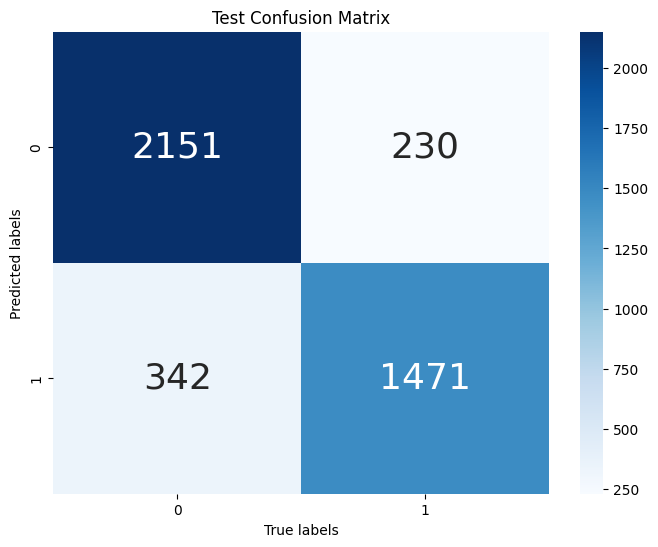

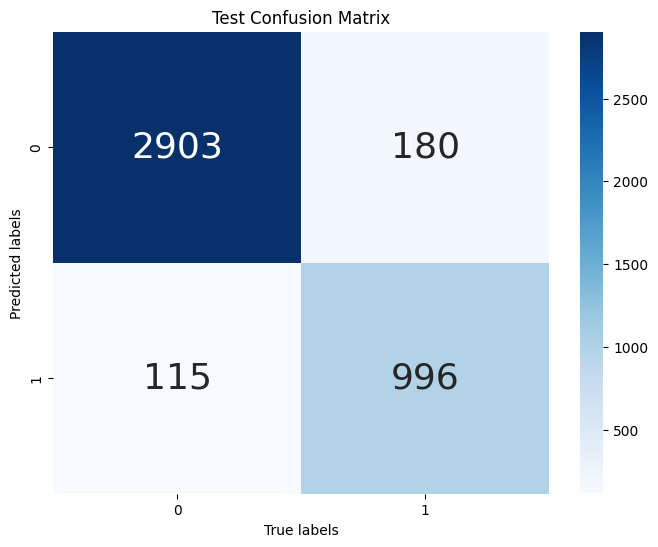

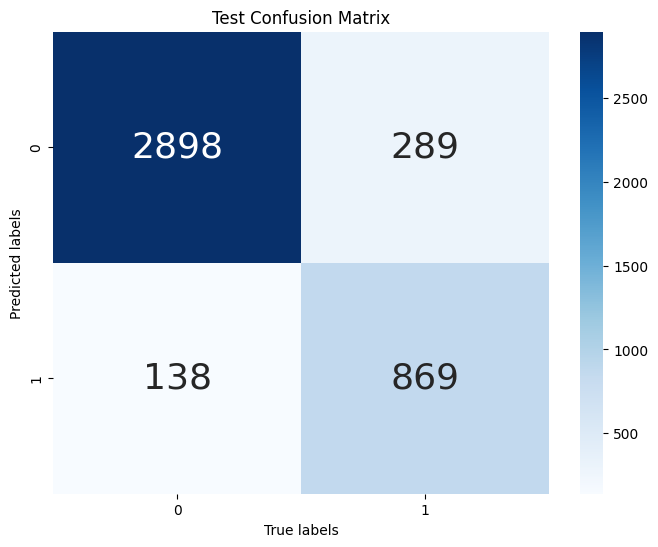

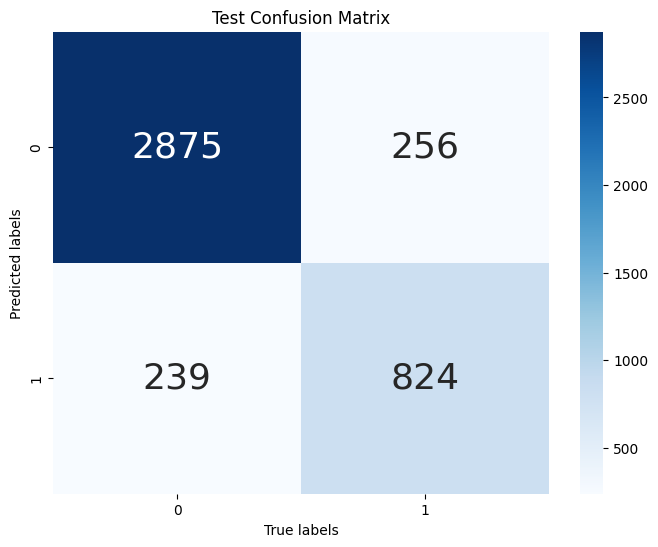

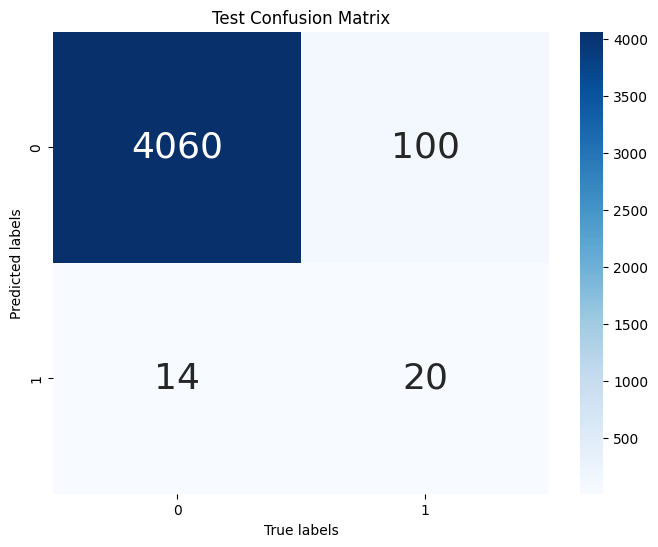

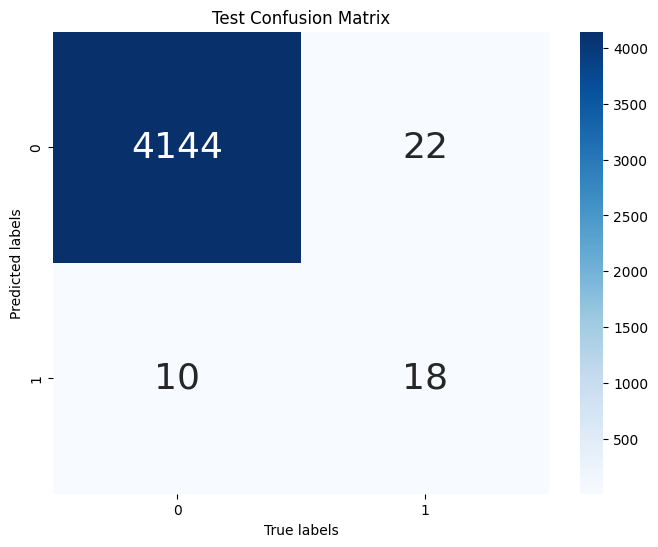

In [34]:
for matrix in confuse_matrix:
    plot_confusion_matrix(matrix)

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [15]:
def test_model(text : str)->list[int]:
  with torch.no_grad():
    encoding = tokenizer.encode_plus(
        text,
        add_special_tokens=True,
        max_length=128,
        return_token_type_ids=False,
        padding='max_length',
        truncation=True,
        return_attention_mask=True,
        return_tensors='pt',
    )

    model_output = model(encoding['input_ids'].flatten().unsqueeze(0).to(device), encoding['attention_mask'].flatten().unsqueeze(0).to(device))
    model_output = model_output.tolist()[0]
  return [0 if label_output[0] > label_output[1] else 1 for label_output in model_output]

In [17]:
test_model("""The dominant sequence transduction models are based on complex recurrent or convolutional neural networks in an encoder-decoder configuration. The best performing models also connect the encoder and decoder through an attention mechanism. We propose a new simple network architecture, the Transformer, based solely on attention mechanisms, dispensing with recurrence and convolutions entirely. Experiments on two machine translation tasks show these models to be superior in quality while being more parallelizable and requiring significantly less time to train. Our model achieves 28.4 BLEU on the WMT 2014 English-to-German translation task, improving over the existing best results, including ensembles by over 2 BLEU. On the WMT 2014 English-to-French translation task, our model establishes a new single-model state-of-the-art BLEU score of 41.8 after training for 3.5 days on eight GPUs, a small fraction of the training costs of the best models from the literature. We show that the Transformer generalizes well to other tasks by applying it successfully to English constituency parsing both with large and limited training data.""")

[1, 0, 0, 0, 0, 0]

In [18]:
test_model("""Training Large Language Models (LLMs)
presents significant memory challenges, predom-
inantly due to the growing size of weights and
optimizer states. Common memory-reduction
approaches, such as low-rank adaptation
(LoRA), add a trainable low-rank matrix to
the frozen pre-trained weight in each layer,
reducing trainable parameters and optimizer
states. However, such approaches typically
underperform training with full-rank weights in
both pre-training and fine-tuning stages since
they limit the parameter search to a low-rank
subspace and alter the training dynamics, and
further, may require full-rank warm start. In this
work, we propose Gradient Low-Rank Projec-
tion (GaLore), a training strategy that allows
full-parameter learning but is more memory-
efficient than common low-rank adaptation
methods such as LoRA. Our approach reduces
memory usage by up to 65.5% in optimizer
states while maintaining both efficiency and
performance for pre-training on LLaMA 1B
and 7B architectures with C4 dataset with up to
19.7B tokens, and on fine-tuning RoBERTa on
GLUE tasks. Our 8-bit GaLore further reduces
optimizer memory by up to 82.5% and total
training memory by 63.3%, compared to a BF16
baseline. Notably, we demonstrate, for the first
time, the feasibility of pre-training a 7B model
on consumer GPUs with 24GB memory (e.g.,
NVIDIA RTX 4090) without model parallel,
checkpointing, or offloading strategies.""")

[1, 0, 0, 1, 0, 0]

In [19]:
test_model("""這些實驗為人類探索原子和分子內的電子世界提供了新工具。皮耶．阿戈斯提尼、費倫茨．克勞斯和安妮．呂利耶展示了一種產生極短光脈衝的方法，可用於測量電子移動或改變能量的快速過程。

當人類感知時，快速移動的事件會相互流動，就像由靜止影像組成的電影被感知為連續的運動一樣。 如果我們想了解非常短暫的事件，我們需要特殊的技術。在電子世界中，變化發生在十分之幾阿秒內——阿秒是如此之短，以至於一秒鐘內可容納的阿秒，多到和宇宙誕生至今的變化一樣多。

獲獎者的實驗製造出如此短的光脈衝，可以以阿秒為單位進行測量，從而顯示了這些脈衝可用來提供原子和分子內部過程的圖像。""")

[0, 1, 0, 0, 0, 0]

In [20]:
test_model("Love is a woman with the ears, and if the men will love, but love is to use your eyes.")

[0, 0, 0, 0, 0, 0]

In [21]:
test_model("""商品屬個人衛生用品，拆封後無猶豫期，如欲退貨請勿拆封❕

若有商品破損、瑕疵、故障等情形，請於收貨後七天內客服告知，請勿以評價作溝通，期限內告知都會幫您處理❕



申請部分退貨後如未達免運及優惠門檻,需補足運費及優惠差額,才可退貨""")

[0, 0, 0, 0, 0, 0]